<a href="https://colab.research.google.com/github/JonChanGit/d2l-zh/blob/master/chapter_recurrent-neural-networks/experiment_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install d2l

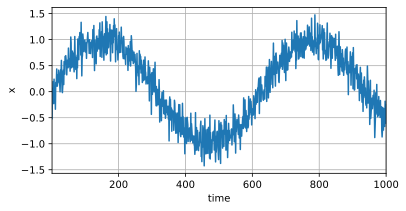

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对 𝑦𝑡=𝑥𝑡 和 𝐱𝑡=[𝑥𝑡−𝜏,…,𝑥𝑡−1]\

In [4]:
# 设置时间滞后（tau）为4，意味着我们用过去的4个时间点的值来预测当前时间点的值。
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
  # 对于每个时间点，都选择其前tau个时间点的值，作为该时间点的特征。
  features[:, i] = x[i:T - tau + i]
# 所有从tau开始到末尾的值作为标签。将每个标签都调整为一个形状为(-1, 1)的二维张量。 torch.Size([996, 1])
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [16]:
train_iter